<a href="https://colab.research.google.com/github/maurosimeonoff/python_fundamentals/blob/main/Automatizaci%C3%B3n_del_reporte_de_hechos_relevantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**MODELO DE PROGRAMA PARA AUTOMATIZACIÓN DEL REPORTE DE HECHOS RELEVANTES**
---
*INSTRUCCIONES DE USO PARA LA EJECUCIÓN:*
```
ENTRADAS:
1.   Bases de datos de demoras, líneas, estructuras y producción.
2.   Fechas de corte deseadas de inicio y de fin del reporte.

SALIDAS:
1.   Texto explicativo con la apertura detallada.
2.   Gráfico resumen.
```

In [ ]:
# Importar la librería Numpy para procesar números y cálculos:
import numpy as np

# Importar la librería Pandas para manejar las bases de datos:
import pandas as pd

# Importar la librería Matplotlib para graficar:
import matplotlib.pyplot as plt

# Importar la librería Datetime para trabajar con fechas y horas:
import datetime as dt

# Importar la librería Operator para realizar funciones básicas con operadores estandarizados:
import operator

# Importar la librería RE para usar expresiones regulares (escribir patrones de texto, y se pueden usar para buscar, reemplazar y manipular texto):
import re

# Instala la biblioteca python-docx (habilitar en caso que no esté instalado)
!pip install python-docx

# Importar el módulo API para crear y manipular documentos de Microsoft Word:
from docx import Document

# Importar la clase Inches para redimensionar el contenido del documento:
from docx.shared import Inches

# Importar la librería OS para manipular archivos y directorios:
import os

In [ ]:
# Importar la base de datos de producción (previamente cargada):
prod_site_df = pd.read_excel ('Produccion.xlsx')

# Importar la base de datos de demoras (previamente cargada):
dem_site_df = pd.read_excel ('Demoras.xlsx')

# Importar la tabla de apoyo: estructura de líneas (previamente cargada):
est_lineas_df = pd.read_excel ('Estructura Lineas.xlsx')

# Importar la tabla de apoyo: estructura de demoras (previamente cargada) y transformar nombres:
est_dem_df = pd.read_excel ('Estructura Demoras.xlsx')

# Importar el listado de líneas:
lineas_df = pd.read_excel ('Lineas DICO.xlsx')

In [ ]:
# Modificar el nombre de las columnas y ajustar tipo de fecha:
prod_site_df.rename(columns = {'COD_DIA':'Fecha', 'COD_SUBLINEA':'codigo'}, inplace = True)
prod_site_df['Fecha'] = pd.to_datetime(prod_site_df['Fecha'], format='%Y%m%d')
prod_site_df['Fecha'] = pd.to_datetime(prod_site_df['Fecha']).dt.date
prod_site_df['DESVIO'] = prod_site_df['PRODREAL'] - prod_site_df['PRODORIGINAL']

# Modificar el nombre de las columnas y ajustar el tipo de fecha:
dem_site_df.rename(columns = {'COD_DIA':'Fecha', 'COD_SUBLINEA':'codigo'}, inplace = True)
dem_site_df['Fecha'] = pd.to_datetime(dem_site_df['Fecha'], format='%Y%m%d')
dem_site_df['Fecha'] = pd.to_datetime(dem_site_df['Fecha']).dt.date
dem_site_df = dem_site_df.replace('Reparación general (rex)','REX')
dem_site_df = dem_site_df.replace('Reparación/mantenimiento programado','RP')

# Modificar nombres de las tablas por acrónimos TX:
est_dem_df= est_dem_df.replace('Reparación general (rex)','REX')
est_dem_df= est_dem_df.replace('Reparación/mantenimiento programado','RP')

In [ ]:
# Cargar los códigos de colores y formato de texto para generar el reporte escrito del modo deseado, utilizando una clase:
class color:
  RED = '\033[91m' # para números negativos.
  BOLD = '\033[1m' # negrita para las líneas y desvíos generales.
  ITALIC = '\033[3m' # para aclaraciones entre paréntesis (reservado para uso futuro).
  GRAY = '\033[90m' # para aclaraciones entre paréntesis (reservado para uso futuro).
  UNDERLINE = '\033[4m' # para subrayados (reservado para uso futuro).
  END = '\033[0m' # se usa para finalizar el formato especial con el que se venía, y retornar al que está por defecto (negro).

# Creación de listas con campos especiales:
lineas_list = est_lineas_df[['COD_PROCESO','DES_PROCESO','COD_SUBLINEA','DES_SUBLINEA','NOMBRELINEACORTO','REGION','PLANTA','UNIDADNEGOCIO']].values.tolist()
lineas_df_list = lineas_df[['Nombre correo','Órden','codigo']].values.tolist()
indicadores_list =['Ut. Disp.', 'Ut. Neta','Ef. Neta','Mix']
tipo_unique = dem_site_df['COD_DEMORA'].unique()
rubro_unique = dem_site_df['COD_DIVISION'].unique()
subrubro_unique = dem_site_df['COD_SUBDIVISION'].unique()

# Creación de diccionarios de demoras por nivel:
tipo_dict = {tipo:list(dem_site_df[dem_site_df.COD_DEMORA == tipo]['DES_DEMORA'].unique()) for tipo in tipo_unique}
rubro_dict = {rubro:list(dem_site_df[dem_site_df.COD_DIVISION == rubro]['DES_DIVISION'].unique()) for rubro in rubro_unique}
subrubro_dict = {subrubro:list(dem_site_df[dem_site_df.COD_SUBDIVISION == subrubro]['DES_SUBDIVISION'].unique()) for subrubro in subrubro_unique}
diccionarios = [tipo_dict,rubro_dict,subrubro_dict]

In [ ]:
# Función para buscar el código de la línea y devolver su descripción:
def cod_linea(linea,lineas_list):
    try:
        for i in range(len(lineas_list)):
                if linea in lineas_list[i]:
                 return int(lineas_list[i][2])
    except:
        return "Linea {} no existe en diccionario".format(linea)

# Función para buscar el código del proceso y devolver su descripción:
def cod_proceso(proceso,lineas_list):
    for i in range(len(lineas_list)):
            if proceso in lineas_list[i]:
             return lineas_list[i][0]
    return "Linea no existe en diccionario"

# Función para buscar el código de la demora y devolver su descripción:
def cod_demora(codigo,diccionario):
    for key,value in diccionario.items():
        if codigo == key:
            return key,value
    return 'Error en cod_demora'

In [ ]:
# Función para establecer qué líneas se deben de explicar en el rango de fechas establecido:
def lineas_DICO(fecha_inicio,fecha_fin,prod_site_df):
    startdate = pd.to_datetime(fecha_inicio).date()
    enddate = pd.to_datetime(fecha_fin).date()
    filtered_prod_site_df = prod_site_df.loc[(prod_site_df['Fecha'] >= startdate)& (prod_site_df['Fecha'] <= enddate)]
    df_listado = pd.DataFrame(filtered_prod_site_df.groupby(['codigo','DES_SUBLINEA'])["DESVIO"].sum())
    df_listado = df_listado[df_listado['DESVIO'] <= -250]
    df_listado = pd.merge(df_listado, lineas_df, how="left", on=["codigo", "codigo"])
    df_listado = df_listado[df_listado['Órden'].notnull()]
    df_listado = df_listado.sort_values(by=['Órden']).reset_index(drop=True)
    codigos_DICO = df_listado[['codigo','Nombre correo']].values.tolist()
    return codigos_DICO

In [ ]:
# Función para explicar los desvíos por utilizacion disponible:
def paradas(desvios_linea,pdd_disp_std,desvio_udisp,desvios_paradas_h):
    desvios_paradas_neg_texto = ''
    desvios_paradas_pos_texto = ''
    desvios_paradas_final_texto = ''
    desvios_paradas = [(i,j,k,l,l/60*pdd_disp_std) for i,j,k,l in desvios_paradas_h]
    desvios_paradas_pos = [(i,j,k,l,m) for i,j,k,l,m in desvios_paradas if m>50]
    desvios_paradas_neg = [(i,j,k,l,m) for i,j,k,l,m in desvios_paradas if m<-50]

    if desvio_udisp<0:
        desvios_tot_paradas_pos = sorted(desvios_paradas_pos, key = operator.itemgetter(3),reverse=True)
        desvios_tot_paradas_neg = sorted(desvios_paradas_neg, key = operator.itemgetter(3),reverse=False)
        for i in range(len(desvios_tot_paradas_neg)):
            desvios_paradas_neg_texto += ' por {} ({} h/{} kt),'.format(desvios_tot_paradas_neg[i][0][1][0],round(desvios_tot_paradas_neg[i][3]/60,1),round(desvios_tot_paradas_neg[i][4]/1000,1))
        for i in range(len(desvios_tot_paradas_pos)):
            desvios_paradas_pos_texto += ' por {} (+{} h/+{} kt),'.format(desvios_tot_paradas_pos[i][0][1][0],round(desvios_tot_paradas_pos[i][3]/60,1),round(desvios_tot_paradas_pos[i][4]/1000,1))
        if len(desvios_paradas_pos) >0:
            desvios_paradas_final_texto = '{}. Gana{}'.format(desvios_paradas_neg_texto[:-1],desvios_paradas_pos_texto[:-1])
        else:
            desvios_paradas_final_texto = '{}'.format(desvios_paradas_neg_texto[:-1])
    elif desvio_udisp>0:
        desvios_tot_paradas_pos = sorted(desvios_paradas_pos, key = operator.itemgetter(3),reverse=True)
        desvios_tot_paradas_neg = sorted(desvios_paradas_neg, key = operator.itemgetter(3),reverse=False)
        for i in range(len(desvios_tot_paradas_neg)):
            desvios_paradas_neg_texto += ' por {} ({} h/{} kt),'.format(desvios_tot_paradas_neg[i][0][1][0],round(desvios_tot_paradas_neg[i][3]/60,1),round(desvios_tot_paradas_neg[i][4]/1000,1))
        for i in range(len(desvios_tot_paradas_pos)):
            desvios_paradas_pos_texto += ' por {} (+{} h/+{} kt),'.format(desvios_tot_paradas_pos[i][0][1][0],round(desvios_tot_paradas_pos[i][3]/60,1),round(desvios_tot_paradas_pos[i][4]/1000,1))
        if len(desvios_paradas_neg)>0:
            desvios_paradas_final_texto = '{}. Pierde{}'.format(desvios_paradas_pos_texto[:-1],desvios_paradas_neg_texto[:-1])
        else:
            desvios_paradas_final_texto = '{}'.format(desvios_paradas_pos_texto[:-1],desvios_paradas_neg_texto[:-1])
    return desvios_paradas_final_texto

# Función para explicar los desvíos por utilización neta:
def interrupciones(desvios_linea,pdd_net_std,desvio_unet,desvios_int_h):
    desvios_int_neg_texto = ''
    desvios_int_pos_texto = ''
    desvios_int_final_texto = ''
    desvios_int = [(i,j,k,l,l/60*pdd_net_std) for i,j,k,l in desvios_int_h]
    desvios_int_pos = [(i,j,k,l,m) for i,j,k,l,m in desvios_int if m>50]
    desvios_int_neg = [(i,j,k,l,m) for i,j,k,l,m in desvios_int if m<-50]

    if desvio_unet<0:
        desvios_tot_int_pos = sorted(desvios_int_pos, key = operator.itemgetter(3),reverse=True)
        desvios_tot_int_neg = sorted(desvios_int_neg, key = operator.itemgetter(3),reverse=False)
        for i in range(len(desvios_tot_int_neg)):
            desvios_int_neg_texto += ' por {} ({} h/{} kt),'.format(desvios_tot_int_neg[i][0][1][0],round(desvios_tot_int_neg[i][3]/60,1),round(desvios_tot_int_neg[i][4]/1000,1))
        for i in range(len(desvios_tot_int_pos)):
            desvios_int_pos_texto += ' por {} (+{} h/+{} kt),'.format(desvios_tot_int_pos[i][0][1][0],round(desvios_tot_int_pos[i][3]/60,1),round(desvios_tot_int_pos[i][4]/1000,1))
        if len(desvios_int_pos) >0:
            desvios_int_final_texto = '{}. Gana{}'.format(desvios_int_neg_texto[:-1],desvios_int_pos_texto[:-1])
        else:
            desvios_int_final_texto = '{}'.format(desvios_int_neg_texto[:-1])
    elif desvio_unet>0:
        desvios_tot_int_pos = sorted(desvios_int_pos, key = operator.itemgetter(3),reverse=True)
        desvios_tot_int_neg = sorted(desvios_int_neg, key = operator.itemgetter(3),reverse=False)
        for i in range(len(desvios_tot_int_neg)):
            desvios_int_neg_texto += ' por {} ({} h/{} kt),'.format(desvios_tot_int_neg[i][0][1][0],round(desvios_tot_int_neg[i][3]/60,1),round(desvios_tot_int_neg[i][4]/1000,1))
        for i in range(len(desvios_tot_int_pos)):
            desvios_int_pos_texto += ' por {} (+{} h/+{} kt),'.format(desvios_tot_int_pos[i][0][1][0],round(desvios_tot_int_pos[i][3]/60,1),round(desvios_tot_int_pos[i][4]/1000,1))
        if len(desvios_int_neg)>0:
            desvios_int_final_texto = '{}. Pierde{}'.format(desvios_int_pos_texto[:-1],desvios_int_neg_texto[:-1])
        else:
            desvios_int_final_texto = '{}'.format(desvios_int_pos_texto[:-1],desvios_int_neg_texto[:-1])
    return desvios_int_final_texto

In [ ]:
# Función para calcular los desvíos de producción y las estructuras de tiempo de cada línea:
def explicaciones_desvios(startdate,enddate,codigo_linea,linea,prod_site_df,dem_site_df):

# Filtro de bases de datos para tomar una sola línea, bases de producción y demoras:
    demoras_df = dem_site_df.loc[(dem_site_df['Fecha'] >= startdate)
                     & (dem_site_df['Fecha'] <= enddate)& (dem_site_df['codigo'] == codigo_linea)]
    produccion_df = prod_site_df.loc[(prod_site_df['Fecha'] >= startdate)
                     & (prod_site_df['Fecha'] <= enddate)& (prod_site_df['codigo'] == codigo_linea)]

# Declaración de variables iniciales:
    h_std = []
    h_real = []
    h_desvio = []
    desvios_linea = []
    cod_name = []

# Crear lista de desvíos en formato: ((Codigo,Nombre), STD, Real, Desvio h, desvío t):
    for dicts in diccionarios:
        for key,value in dicts.items():
            h_std += [demoras_df.loc[(demoras_df['COD_DEMORA']==key)|(demoras_df['COD_DIVISION']==key)|(demoras_df['COD_SUBDIVISION']==key)]['MINUTOSSTDDIA'].sum()]
            h_real += [demoras_df.loc[(demoras_df['COD_DEMORA']==key)|(demoras_df['COD_DIVISION']==key)|(demoras_df['COD_SUBDIVISION']==key)]['MINUTOSREALDIA'].sum()]
            h_desvio = [std-real for (std,real) in zip(h_std,h_real)]
            cod_name.append(cod_demora(key,dicts))
            desvios_linea = list(zip(cod_name,h_std,h_real,h_desvio))

# Obtener información de demoras para el cálculo de estructuras de tiempos siendo los datos de entrada minutos:
    paradas_real = [item[2] for item in desvios_linea if item[0][0] == 2000][0]
    paradas_std = [item[1] for item in desvios_linea if item[0][0] == 2000][0]
    interrupciones_real = [item[2] for item in desvios_linea if item[0][0] == 1000][0]
    interrupciones_std = [item[1] for item in desvios_linea if item[0][0] == 1000][0]
    estructurales_real = [item[2] for item in desvios_linea if item[0][0] == 2400][0]
    estructurales_std = [item[1] for item in desvios_linea if item[0][0] == 2400][0]
    rex_real = [item[2] for item in desvios_linea if item[0][0] == 2220][0]
    rex_std = [item[1] for item in desvios_linea if item[0][0] == 2220][0]

# Cálculo del tiempo calendario en base al número de días inicial y final:
    tcal = ((enddate-startdate).days+1)*24

# Cálculo de la estructura de tiempos real, llevando la información a horas:
    tdisp_real = tcal-(paradas_real/60)
    tpos_real = tcal-(rex_real/60)-(estructurales_real/60)
    tnet_real = tdisp_real - (interrupciones_real/60)
    utot_real = tnet_real/tcal
    udisp_real = tdisp_real/tcal
    upos_real = tnet_real/tpos_real
    unet_real = tnet_real/tdisp_real

# Cálculo de la estructura de tiempos estándares, llevando la información a horas:
    tdisp_std = tcal-(paradas_std/60)
    tpos_std = tcal-(rex_std/60)-(estructurales_std/60)
    tnet_std = tdisp_std - (interrupciones_std/60)
    tnet_flex = (produccion_df['TIEMPONETOSTDFLEX'].sum())/60
    utot_std = tnet_std/tcal
    udisp_std = tdisp_std/tcal
    upos_std = tnet_std/tpos_std
    unet_std = tnet_std/tdisp_std
    unet_flex = tnet_flex/tdisp_std
    tdisp_flex = tnet_flex/unet_flex

# Cálculo de información producción:
    prod_real = produccion_df['PRODREAL'].sum()
    prod_orig = produccion_df['PRODORIGINAL'].sum()
    coef_prog = produccion_df['COEFICIENTEPROG'].mean()
    desvio_tns = prod_real-prod_orig
    pdd_disp_real = prod_real/tdisp_real
    pdd_net_real = prod_real/tnet_real
    pdd_disp_obj = prod_orig/tdisp_std
    pdd_disp_std = prod_real/tdisp_std
    pdd_net_obj = prod_orig/tnet_std
    pdd_net_std = prod_real/tnet_flex
    pdd_disp_flex = pdd_net_std*unet_std

# Cálculo de desvío de indicadores:
    desvio_mix = tdisp_std*(pdd_disp_flex-pdd_disp_obj)
    desvio_udisp = (tdisp_real-tdisp_std)*pdd_disp_flex
    desvio_unet = tdisp_real*(unet_real-unet_std)*pdd_net_std
    desvio_pddnet = tdisp_real*unet_real*(pdd_net_real-pdd_net_std)
    desvio_tot = desvio_mix+desvio_udisp+desvio_unet+desvio_pddnet
    desvios = [desvio_udisp,desvio_unet,desvio_pddnet,desvio_mix]
    desvios_int_h = [item for item in desvios_linea if (item[0][0] < 2000) & (item[0][0]%100 != 0)]
    desvios_paradas_h = [item for item in desvios_linea if (item[0][0] > 2000) & (item[0][0]%100 != 0)]
    explicaciones = explicaciones_linea(prod_real,desvio_tns,codigo_linea,linea,indicadores_list,desvios,desvio_udisp,desvios_paradas_h,pdd_disp_std,desvio_unet,desvios_int_h,pdd_net_std)
    return explicaciones

In [ ]:
# Declaración de variables iniciales:
h_std = []
h_real = []
h_desvio = []
desvios_linea = []
cod_name = []

# Generación del texto:
def explicaciones_linea(prod_real,desvio_tns,codigo_linea,linea,indicadores_list,desvios,desvio_udisp,desvios_paradas_h,pdd_disp_std,desvio_unet,desvios_int_h,pdd_net_std):
    explicaciones_paradas = paradas(desvios_linea,pdd_disp_std,desvio_udisp,desvios_paradas_h)
    explicaciones_int = interrupciones(desvios_linea,pdd_net_std,desvio_unet,desvios_int_h)
    zipped = list(zip(indicadores_list,desvios))
    desvios_pos = [(i,j) for (i,j) in zipped if j>=0]
    desvios_neg = [(i,j) for (i,j) in zipped if j<0]
    desvios_final = ''
    formato_END=color.END
    apertura = ""
    anexo =""
    intro = ": "
    formato_linea = color.BOLD
    if desvio_tns == 0:
        formato_color = ''
        if prod_real ==0 & prod_orig == 0:
            print("La línea no tuvo producción")
        else:
            print("La línea no tiene desvíos")
    elif desvio_tns <0:
        signo = '-'
        formato_color = color.RED
        desvios_tot = sorted(zipped, key = operator.itemgetter(1),reverse=False)
        for i in range(len(desvios_tot)):
            if desvios_tot[i][1]>=0:
                signo_ind = '+'
                color_ind=''
                if desvios_tot[i][0]=='Ut. Neta':
                    desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+'; '
                elif desvios_tot[i][0]=='Ut. Disp.':
                    desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+'{}; '.format(explicaciones_paradas)
                else:
                    desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+'; '
            else:
                signo_ind=''
                color_ind=color.RED
                if desvios_tot[i][0]=='Ut. Neta':
                    desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+'{}; '.format(explicaciones_int)
                elif desvios_tot[i][0]=='Ut. Disp.':
                    desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+'{}; '.format(explicaciones_paradas)
                else:
                    desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+' {}; '
    elif desvio_tns>0:
        signo = '+'
        formato_color = ''
        desvios_tot = sorted(zipped, key = operator.itemgetter(1),reverse=True)
        for i in range(len(desvios_tot)):
            if desvios_tot[i][1]>=0:
                signo_ind = '+'
                color_ind=''
            else:
                signo_ind=''
                color_ind=color.RED
            if desvios_tot[i][0]=='Ut. Neta':
                desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+'{}; '.format(explicaciones_int)
            elif desvios_tot[i][0]=='Ut. Disp.':
                desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+'{}; '.format(explicaciones_paradas)
            else:
                desvios_final += str(desvios_tot[i][0])+color_ind+' ('+str(signo_ind)+str(round(desvios_tot[i][1]/1000,1))+' kt)'+color.END+' {}; '
    texto = '{}{}{} {}({}{} kt/{}{}%){}{}{}{}.\n'.format(formato_linea,linea,formato_color,apertura,signo,abs(round(desvio_tns/1000,1)),signo,round(abs(desvio_tns/prod_real)*100,1),formato_END,intro,anexo,desvios_final[:-2])
    return print(texto)

In [ ]:
# Función principal para la generación del texto procesado:
def explicaciones_DICO(fecha_inicio,fecha_fin,prod_site_df,dem_site_df):
  formato_linea = color.BOLD
  formato_END=color.END
  explicaciones_final=[]
  startdate = pd.to_datetime(fecha_inicio).date()
  enddate = pd.to_datetime(fecha_fin).date()
  codigos_DICO = lineas_DICO(fecha_inicio,fecha_fin,prod_site_df)
  detalle = 'Cantidad de líneas: {} \n'.format(len(codigos_DICO))

# Entrega de una lista de lineas con códigos y nombres, iterando a la siguiente explicación:
  print() # para espaciado
  print('\033[1mReporte de hechos relevantes desde ' + fecha_inicio + ' hasta ' + fecha_fin + ':\033[0m')
  print() # para espaciado

# Cálculo de la explicacion pora cada línea:
  for i in range(len(codigos_DICO)):
    codigo_linea = codigos_DICO[i][0]
    linea = codigos_DICO[i][1]
    try:
      explicaciones = explicaciones_desvios(startdate,enddate,codigo_linea,linea,prod_site_df,dem_site_df)
    except:
        print('La linea {} tiene errores'.format(linea))
        return explicaciones

In [ ]:
# Función para validar el formato de fecha de entrada "aaaa-mm-dd":
def validar_formato_fecha(fecha):
    pattern = r"^\d{4}-\d{2}-\d{2}$"
    return re.match(pattern, fecha)

# Función para comparar fechas y evitar que se ingrese una fecha de fin anterior a la de inicio:
def fecha_fin_posterior(fecha_inicio, fecha_fin):
    return fecha_inicio <= fecha_fin

# Solicitar al usuario que ingrese la fecha inicio en formato "YYYY-MM-DD" (ejemplo: fecha inicio "2023-06-01"):
fecha_inicio = input("Ingrese fecha de inicio (en formato 'YYYY-MM-DD') para construir el reporte: ")
while not validar_formato_fecha(fecha_inicio):
    fecha_inicio = input("Formato incorrecto. Ingrese fecha de inicio en formato 'YYYY-MM-DD': ")

# Solicitar al usuario que ingrese la fecha fin en formato "YYYY-MM-DD" (ejemplo: fecha fin "2023-06-30"):
fecha_fin = input("Ingrese la fecha de fin (en formato 'YYYY-MM-DD') para construir el reporte: ")
while not validar_formato_fecha(fecha_fin) or not fecha_fin_posterior(fecha_inicio, fecha_fin):
    if not validar_formato_fecha(fecha_fin):
        fecha_fin = input("Formato incorrecto. Ingrese fecha de fin en formato 'YYYY-MM-DD': ")
    else:
        fecha_fin = input("La fecha de fin debe ser posterior o igual a la fecha de inicio. Ingrese una fecha válida: ")

# Cargar las explicaciones según las fechas ingresadas:
explicaciones_DICO(fecha_inicio, fecha_fin, prod_site_df, dem_site_df)

Ingrese fecha de inicio (en formato 'YYYY-MM-DD') para construir el reporte: 2023-06-01
Ingrese la fecha de fin (en formato 'YYYY-MM-DD') para construir el reporte: 2023-06-30

Reporte de hechos relevantes desde 2023-06-01 hasta 2023-06-30:

Galva 1 JUV (-0.3 kt/-3.1%): Ef. Neta (-5.6 kt) {}; Ut. Neta (-0.1 kt); Ut. Disp. (+0.3 kt) por RP (+22.0 h/+0.3 kt). Pierde por Cambios operativos (-7.7 h/-0.1 kt); Mix (+5.0 kt).

Galva 3 JUV (-0.5 kt/-4.1%): Ef. Neta (-6.5 kt) {}; Ut. Disp. (-0.0 kt); Ut. Neta (+0.0 kt); Mix (+6.0 kt).

Galva 3 UNI (-1.1 kt/-9.4%): Ef. Neta (-8.5 kt) {}; Ut. Disp. (-0.4 kt) por Falta de materia prima (-20.4 h/-0.4 kt), por Falta de espacio para evac./desb. entre líneas (-15.2 h/-0.3 kt), por Cambio de producto o medida (-5.4 h/-0.1 kt), por Energía y servicios (-3.6 h/-0.1 kt). Gana por REX (+27.0 h/+0.5 kt), por Cambios operativos (+3.1 h/+0.1 kt); Ut. Neta (-0.0 kt) por Servicios centrales (-3.0 h/-0.1 kt); Mix (+7.9 kt).

Galva Mva (-0.9 kt/-5.5%): Ef. Neta (


# **PROPUESTAS DE MEJORA PARA DESARROLLO FUTURO**
*FUNCIÓN:*
1. Agregar selección de "Criterio de jerarquización de desvío" (absoluto o relativo) para el ordenamiento automático y filtrado de modo que el usuario pueda ingresar el modo (si es de modo "Relativo" (por defecto), ejemplo: <=-%5 o modo "Absoluto" ejemplo <=-250 t como cifras sugeridas), siendo dichos parámetros en ambos casos variables modificables. Si el desvío es positivo, la barra resultante debe mostrarse en color verde, o bien permitir al usuario no mostrar los desvíos mayores a -5% como parámetro elegible (modo "Resumen ejecutivo").
3. El gráfico de desvío podría abrirse columnas positivas o negativas que muestren su motivo (utilización neta, utiliación disponible, eficiencia neta, mezcla de productos o coefieciente de programación).
4. El objeto gráfico podría ser interactivo conduciendo ágilmente con un clic selectivo de la línea a la apertura textual explicativa de la causan del desvío.
5. Considerar las líneas donde puede aplicar coeficiente de programación (cuando aplique el concepto).
6. Exportación del texto directamente a un archivo Word.docx.

*FORMATO:*
1. Incorporar formato en itálica y color gris para el texto que figura entre paréntesis como aclaraciones y eventuales subrayados (homologación de criterio de escritura/unidades TX).
2. Reemplazar masivamente las variables i, j, k, l y m por nombres que sean más descriptivos.
3. Aclarar o vincular los códigos de ítems 2000, 1000, 2400 y 2200 a una tabla descriptiva.
4. Cuando el resultado de la explicación trae "{}","{Ingresar texto explicativo aquí.}"

El archivo 'Principales desvíos de producción - Argentina (desde 2023-06-01 hasta 2023-06-30).docx' ha sido creado exitosamente.


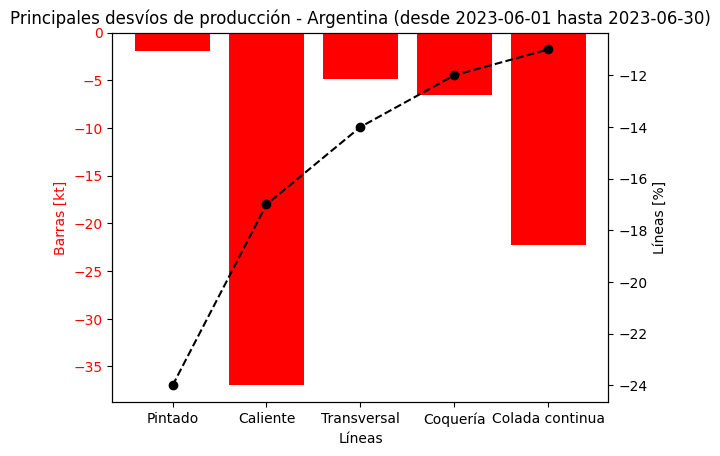

In [ ]:
# Generación del documento Word.docx con un gráfico resumen incrustado (en desarrollo: datos de prueba no vinculados al programa)

# Carga de datos para el gráfico de barras y la línea:
categorias = ['Pintado', 'Caliente', 'Transversal', 'Coquería', 'Colada continua']
valores_barras = [-1.9, -36.9, -4.9, -6.5, -22.3]
valores_linea = [-24, -17, -14, -12, -11]

# Crear el gráfico de barras:
fig, ax1 = plt.subplots()

# Graficar las barras en el eje vertical izquierdo con color rojo:
ax1.bar(categorias, valores_barras, color='r', label='Barras')
ax1.set_xlabel('Líneas')
ax1.set_ylabel('Barras [kt]', color='r')

# Configurar el eje vertical izquierdo con etiquetas rojas:
ax1.tick_params(axis='y', labelcolor='r')

# Crear el segundo eje compartiendo el mismo eje x:
ax2 = ax1.twinx()

# Graficar la línea en el eje vertical derecho con color negro:
ax2.plot(categorias, valores_linea, color='k', linestyle='--', marker='o', label='Línea')
ax2.set_ylabel('Líneas [%]', color='k')

# Configuración del eje derecho con etiquetas de color negro:
ax2.tick_params(axis='y', labelcolor='k')

# Mostrar el gráfico con un título dinámico en función del país y las fechas elegidas:
plt.title('Principales desvíos de producción - Argentina (desde ' + fecha_inicio + ' hasta ' + fecha_fin + ')')

# Obtener el objeto de figura para establecer su tamaño:
fig_obj = plt.gcf()
fig_obj.savefig('Imagen_principales_desvíos_de_produccíon.png', bbox_inches='tight', dpi=300)

# Generar el nombre del archivo con las fechas dinámicas:
nombre_archivo = f"Principales desvíos de producción - Argentina (desde {fecha_inicio} hasta {fecha_fin}).docx"

# Crear el documento:
doc = Document()

# Agregar el gráfico al documento:
doc.add_picture('Imagen_principales_desvíos_de_produccíon.png', width=Inches(5))

# Guardar el documento como un archivo Word e informar:
doc.save(nombre_archivo)
print(f"El archivo '{nombre_archivo}' ha sido creado exitosamente.")

# Eliminar la imagen guardada en los archivos temporales de Colab:
os.remove('Imagen_principales_desvíos_de_produccíon.png')